In [1]:
# imports

import requests
import zipfile
import io

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from fastai.collab import CollabDataLoaders, collab_learner, tensor, nn, load_learner

# Configs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"   # to print multiple lines in a cell

plt.style.use('ggplot')   # use ggplot style for plots

In [2]:
# global vars

MOVIELENS_LATEST_URL = "https://files.grouplens.org/datasets/movielens/ml-latest.zip"

# A movie recommender based on similarity

Using the MovieLens [(large) dataset](https://files.grouplens.org/datasets/movielens/ml-latest-README.html) of user ratings. The dataset should update regularly.

We will use a notion of similarity as learned from user ratings on movies and will follow the concepts exposed in [lessons 7/8](https://www.kaggle.com/code/jhoward/collaborative-filtering-deep-dive) of the fast.ai "Practical Deep Learning for coders" course. We will use the whole Movielens dataset (as opposed to a subset), curating it.


## Download and sort the data

In [3]:
# download the data locally - note: it will disappear when runtime is shut
response = requests.get(MOVIELENS_LATEST_URL)
response.status_code  # just to make sure we're getting a 200

# Unzip to local folder
with zipfile.ZipFile(io.BytesIO(response.content)) as zfile:
  zfile.extractall('.')   # will create a local folder ml-latest

200

In [4]:
# read the ratings into a df
df_ratings = pd.read_csv('ml-latest/ratings.csv')

# same for movies (contains titles, which reports movie release year)
df_movies = pd.read_csv('ml-latest/movies.csv')

In [5]:
# add date col from the timestamp - this is just for human friendliness
df_ratings['date'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

# also add column for year-month
df_ratings['year_month'] = df_ratings['date'].dt.to_period('M')

# split the movie year from the title into own col
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)')

In [6]:
df_ratings.head(3)
df_movies.head(3)
df_movies.dtypes

,userId,movieId,rating,timestamp,date,year_month
0,1,1,4.0,1225734739,2008-11-03 17:52:19,2008-11
1,1,110,4.0,1225865086,2008-11-05 06:04:46,2008-11
2,1,158,4.0,1225733503,2008-11-03 17:31:43,2008-11


,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995


,0
movieId,int64
title,object
genres,object
year,object


## Basic EDA & cleanses

In [7]:
len(df_ratings), df_ratings['userId'].nunique(), df_ratings['movieId'].nunique()

# min and max date of ratings
df_ratings['date'].min(), df_ratings['date'].max()

# most recent movies
df_movies.sort_values('year', ascending=False).head(3)

# unique genres
df_movies['genres'].str.split('|').explode().unique()

(33832162, 330975, 83239)

(Timestamp('1995-01-09 11:46:44'), Timestamp('2023-07-20 08:53:33'))

,movieId,title,genres,year
84803,282937,Norwegian Dream (2023),Drama,2023
85479,285365,Unexpected Grace (2023),Drama|Romance,2023
85974,287057,Marui Video (2023),Horror|Mystery|Thriller,2023


array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [8]:
# movies with the most and least ratings
df_tmp = df_ratings.groupby('movieId')['rating'].count().reset_index()
df_tmp.sort_values('rating', ascending=False).head(3)
df_tmp.sort_values('rating', ascending=False).tail(3)

# how many movies with less than x ratings
len(df_tmp[df_tmp['rating'] < 100])

# movie with highest num of ratings
max_rating = df_tmp['rating'].max()
df_movies[df_movies.movieId==df_tmp[df_tmp['rating'] == max_rating]['movieId'].iloc[0]]

,movieId,rating
314,318,122296
351,356,113581
292,296,108756


,movieId,rating
69018,230871,1
40104,161700,1
83238,288983,1


70986

,movieId,title,genres,year
314,318,"Shawshank Redemption, The (1994)",Crime|Drama,1994


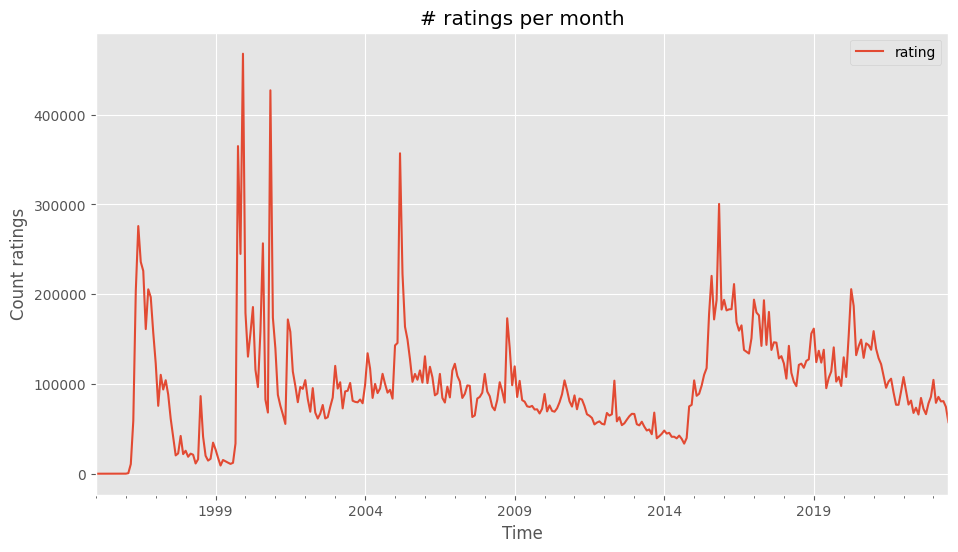

In [9]:
# number of rtings per year_month, time series plot
df_tmp = df_ratings.groupby('year_month')['rating'].count().reset_index()
df_tmp.plot(x='year_month', y='rating', figsize=(11, 6));
plt.title('# ratings per month');
plt.xlabel('Time');
plt.ylabel('Count ratings');

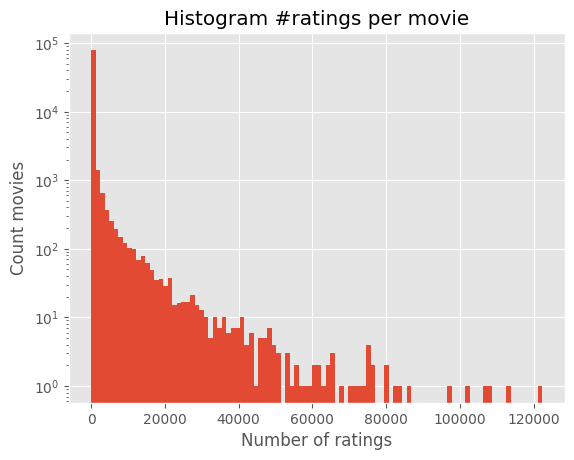

In [10]:
# distribution of ratings per movie
df_tmp = df_ratings.groupby('movieId')['rating'].count().reset_index()
df_tmp['rating'].plot.hist(bins=100, log=True);
plt.title('Histogram #ratings per movie');
plt.xlabel('Number of ratings');
plt.ylabel('Count movies');

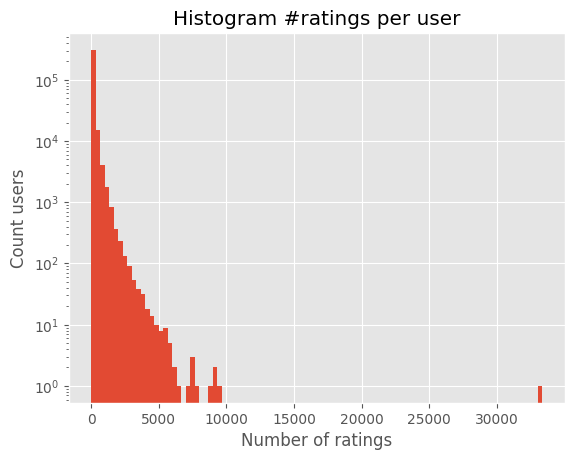

In [11]:
# distribution of ratings per user
df_tmp = df_ratings.groupby('userId')['rating'].count().reset_index()
df_tmp['rating'].plot.hist(bins=100, log=True);
plt.title('Histogram #ratings per user');
plt.xlabel('Number of ratings');
plt.ylabel('Count users');

In [12]:
df_tmp = df_ratings.groupby('userId')['rating'].count().reset_index()

df_tmp.sort_values('rating', ascending=False).head(3)

,userId,rating
189613,189614,33332
48765,48766,9554
207215,207216,9178


<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Histogram avg rating per movie')

Text(0.5, 0, 'Avg rating')

Text(0, 0.5, 'Count movies')

,movieId,rating
count,83239.000000,83239.000000
mean,155280.437415,3.012706
std,78926.635815,0.790872
min,1.000000,0.500000
25%,107770.000000,2.571429
50%,165131.000000,3.083333
75%,211276.000000,3.500000
max,288983.000000,5.000000


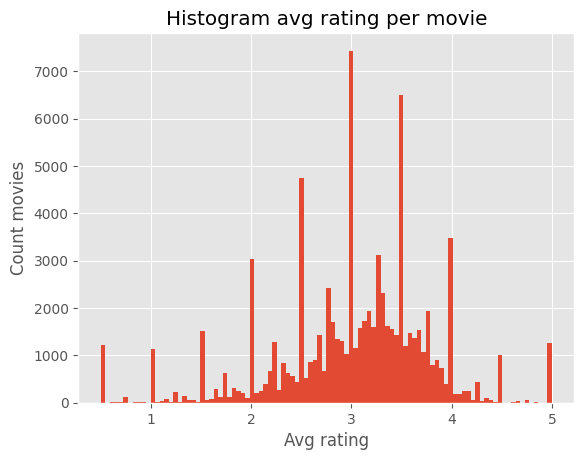

In [13]:
# avg rating per movie and draw distrib too
df_tmp = df_ratings.groupby('movieId')['rating'].mean().reset_index()

df_tmp['rating'].plot.hist(bins=100);
plt.title('Histogram avg rating per movie');
plt.xlabel('Avg rating');
plt.ylabel('Count movies');

df_tmp.describe()

In [14]:
1# remove movies whose avg rating is below 3.5
df_tmp = df_ratings.groupby('movieId')['rating'].mean().reset_index()
df_tmp = df_tmp[df_tmp['rating'] >= 3.5]
df_ratings = df_ratings[df_ratings['movieId'].isin(df_tmp['movieId'])]
df_movies = df_movies[df_movies['movieId'].isin(df_tmp['movieId'])]

1

In [15]:
# remove movies with less than x ratings overall
df_tmp = df_ratings.groupby('movieId')['rating'].count().reset_index()
df_tmp = df_tmp[df_tmp['rating'] >= 1000]
df_ratings = df_ratings[df_ratings['movieId'].isin(df_tmp['movieId'])]
df_movies = df_movies[df_movies['movieId'].isin(df_tmp['movieId'])]

In [16]:
# remove users with less than y ratings overall
df_tmp = df_ratings.groupby('userId')['rating'].count().reset_index()
df_tmp = df_tmp[df_tmp['rating'] >= 500]
df_ratings = df_ratings[df_ratings['userId'].isin(df_tmp['userId'])]

## Sample

So to have a smaller number of ratings overall but preserving the distribution of ratings per movie.

In [17]:
# for each movie, sample the ratings so to have the same proportion of each type of rating

f = 0.1  # proportion total we want
df_ratings = df_ratings.groupby(['movieId', 'rating'], group_keys=False).apply(lambda x: x.sample(frac=f))

<ipython-input-17-438573dba0c7>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ratings = df_ratings.groupby(['movieId', 'rating'], group_keys=False).apply(lambda x: x.sample(frac=f))


In [18]:
len(df_ratings), df_ratings['userId'].nunique(), df_ratings['movieId'].nunique()

(213955, 3102, 2145)

In [19]:
# merge into single dataset
df = pd.merge(df_ratings, df_movies, on='movieId')
df.head(2)

,userId,movieId,rating,timestamp,date,year_month,title,genres,year
0,315017,1,0.5,1462969114,2016-05-11 12:18:34,2016-05,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,230369,1,0.5,1589035050,2020-05-09 14:37:30,2020-05,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995


In [20]:
# check if some movies I know are in the set

movie_ids = list(set(df_ratings['movieId'].tolist()))

df_movies[(df_movies['movieId'].isin(movie_ids)) &  (df_movies['title'].str.contains('Hidden Figures'))]
df_movies[(df_movies['movieId'].isin(movie_ids)) &  (df_movies['title'].str.contains('Paddington'))]

,movieId,title,genres,year
44234,166643,Hidden Figures (2016),Drama,2016


,movieId,title,genres,year
23412,117887,Paddington (2014),Children|Comedy,2014
50032,178827,Paddington 2 (2017),Adventure|Animation|Children|Comedy,2017


## Learn


In [21]:
# build dataloaders
dls = CollabDataLoaders.from_df(df,
                                user_name='userId',  # picks first col as default which should be this already, but to be safe
                                item_name='title',
                                rating_name='rating',
                                valid_pct=0.2,       # default value, will not change
                                bs=64)
dls.show_batch()

,userId,title,rating
0,248601,"Nightmare Before Christmas, The (1993)",3.0
1,183692,In the Heat of the Night (1967),4.5
2,289344,Grizzly Man (2005),3.5
3,137547,Blow-Up (Blowup) (1966),4.0
4,11717,Indiana Jones and the Temple of Doom (1984),3.0
5,232080,American Beauty (1999),4.0
6,288686,"Matrix, The (1999)",5.0
7,125743,Gods and Monsters (1998),5.0
8,42705,"Fugitive, The (1993)",2.0
9,44054,Young Frankenstein (1974),4.0


In [22]:
# run a collab_learner (EmbeddingDotBias model) with 50 latent factors
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), use_nn=False)   # 5.5 because 5 is max score

# and fit it
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.625814,0.669951,00:31
1,0.534027,0.655734,00:32
2,0.395223,0.630101,00:29
3,0.365085,0.608018,00:32
4,0.365898,0.603234,00:29


In [112]:
# save the trained model
learn.export('model_5_gpu_title3')

# you need to download it from this FS to keep it

In [23]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(3103, 50)
  (i_weight): Embedding(2146, 50)
  (u_bias): Embedding(3103, 1)
  (i_bias): Embedding(2146, 1)
)

In [28]:
# read saved model
learn = load_learner('model_5_cpu_title.pkl')

## Analyse

In [29]:
# check the movies with the highest/lowest bias
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=False)[:5]   # True/False
df_movies[df_movies.title.isin([dls.classes['title'][i] for i in idxs])]

,movieId,title,genres,year
334,339,While You Were Sleeping (1995),Comedy|Romance,1995
1626,1688,Anastasia (1997),Adventure|Animation|Children|Drama|Musical,1997
5880,5991,Chicago (2002),Comedy|Crime|Drama|Musical,2002
11216,49286,"Holiday, The (2006)",Comedy|Romance,2006
18842,98243,Rise of the Guardians (2012),Adventure|Animation|Children|Fantasy|IMAX,2012


In [30]:
movie_factors = learn.model.i_weight.weight

In [31]:
df_movies[df_movies['title'].str.contains('Mary Poppins')]

,movieId,title,genres,year
1005,1028,Mary Poppins (1964),Children|Comedy|Fantasy|Musical,1964


In [37]:
idx = dls.classes['title'].o2i['Paddington (2014)']
idx = dls.classes['title'].o2i['Hidden Figures (2016)']
#idx = dls.classes['title'].o2i['Mary Poppins (1964)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idxs = distances.argsort(descending=True)[1:6]
dls.classes['title'][idxs]

(#5) ['Best Exotic Marigold Hotel, The (2011)','Hacksaw Ridge (2016)','Sully (2016)','Impossible, The (Imposible, Lo) (2012)','Saving Mr. Banks (2013)']

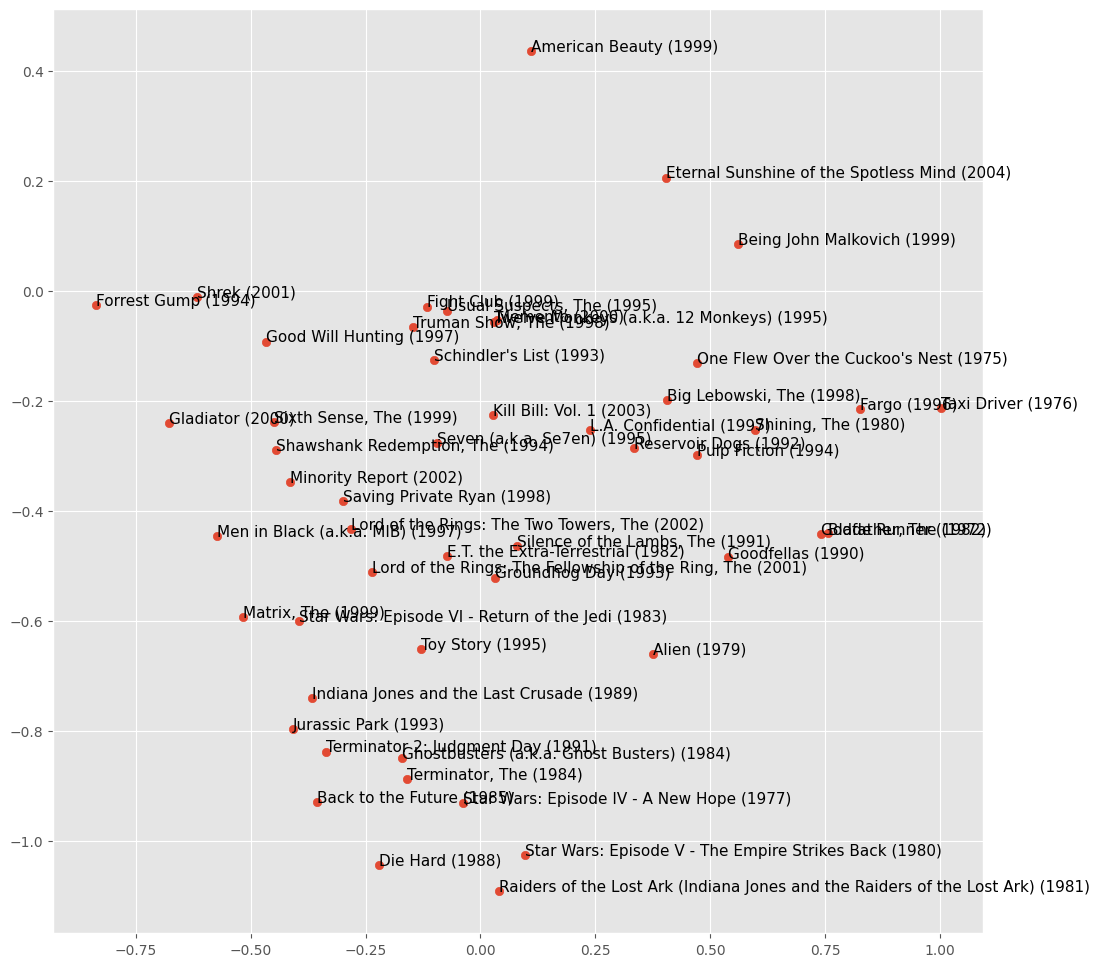

In [134]:
# change params here as desired

g = df.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]  # movies with the most ratings
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
#movie_w = learn.model.movie_factors[top_idxs].detach()
movie_w = movie_factors[top_idxs].detach()
movie_pca = movie_w.pca(3)
fac0, fac1, fac2 = movie_pca.t()
idxs = list(range(50))

X = fac0[idxs].cpu()   # add .cpu if using the TPU, here and below
Y = fac2[idxs].cpu()
plt.figure(figsize=(12,12));
plt.scatter(X, Y);

# adding labels
for i, x, y in zip(top_movies, X, Y):
    # title = df_movies[df_movies.movieId==i]['title'].iloc[0]
    plt.text(x, y, i,
             #color=np.random.rand(3)*0.7,
             fontsize=11);
plt.show();